# Jupyter Notebook to Processing Pipeline


Task: 
* Translate a trained model within a notebook to a processing pipeline

Assumption:
* Model is completely trained.

Inputs: 
* Images or Video

High-level instruction to address the following Task:
1. Load the trained model. 
2. Capture input from source. 
3. Convert input to a floating point. 
4. Use preprocessing methods for improving quality such as smoothing to reduce gaussian noise, sharpening, etc.  
5. Resize the image to the size of images trained. 
6. If necessary, normalize the inputs and convert to tensor.
7. Display relevant out puts for users.
8. Create a container via docker or singularity. Optionally, create a API with FastAPI or Flask for deployment. 


The code below should run and is an example of the processes I would take. 



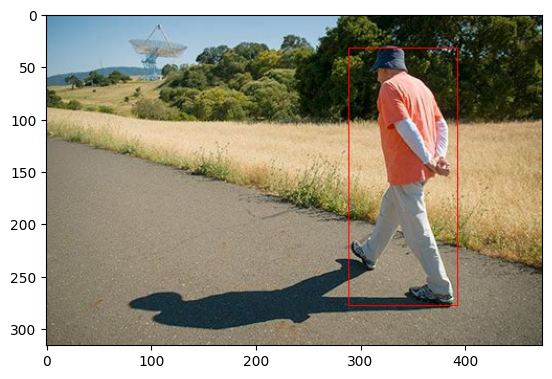

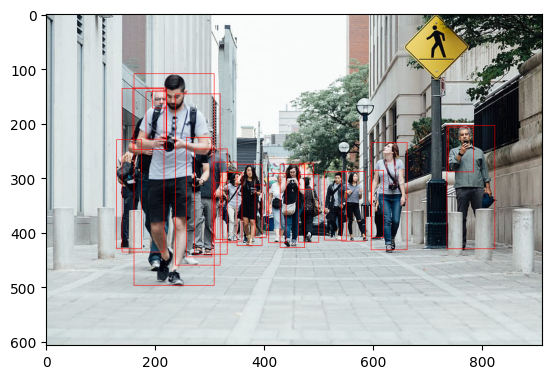

In [ ]:
from torchvision.models.detection import mask_rcnn
import torch
import torch.nn as nn
import torchvision

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from skimage.io import imread, imsave
from skimage.filters import gaussian

torch.cuda.empty_cache() # Always empty the cache



class GaitAnalysisInference(object):

    def __init__(self, model_name: str="mask_rcnn") -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model_name = model_name
        self.model = self.load_model()
        self.model.eval()

        self.image_size = [512,512]

    def load_model(self):
        if self.model_name == "mask_rcnn":
            self.weights_coco = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
            return torchvision.models.detection.maskrcnn_resnet50_fpn(
                weights=weights_coco
            ).to(self.device)
        else: 
            # Other models
            pass

    def draw_bounding_box(self, image: np.array, bboxes: np.array) -> np.array:
        pil_img = Image.fromarray(image)
        
        for bbox in bboxes:
            xy = [tuple(bbox[:2]), tuple(bbox[2:])]
            
            draw = ImageDraw.Draw(pil_img)
            draw.rectangle(xy, outline=(255,0,0))
        
        return np.array(pil_img)
    
    def preprocessing(self, image: np.array) -> torch.Tensor:

        image = (image.transpose(2,0,1))/255.
        image = gaussian(image, sigma=0.4)
        tensor_img = torch.Tensor(image)

        # Mask R-CNN does the resizing and normalization for the image.
        # tensor_img = torchvision.transforms.functional.resize(tensor_img, self.image_size)
        # tensor_img = torchvision.transforms.functional.normalize(tensor_img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        return tensor_img.unsqueeze(0).to(self.device)
    
    def run(self, image: np.array) -> np.array:
        """
        Run inference for Gait Analysis software.
        """

        tensor_img = self.preprocessing(image)
        output = self.model(tensor_img)
        
        person_idx = self.weights_coco.meta['categories'].index("person") 
        keep_detection_bool = np.where(output[0]["labels"].detach().cpu().numpy() == person_idx)

        boxes = output[0]["boxes"].detach().cpu().numpy()[keep_detection_bool]
        labels = output[0]["labels"].detach().cpu().numpy()[keep_detection_bool]

        annotated_image = self.draw_bounding_box(image, bboxes=boxes)
        
        return annotated_image



# I would use some argparser here too

inference = GaitAnalysisInference()

img = imread("walking.jpg")
annotated_img = inference.run(img)
plt.imshow(annotated_img)
plt.show()

img = imread("walking2.jpg")
annotated_img = inference.run(img)
plt.imshow(annotated_img)
plt.show()

# Demo Sheep Classifier





In [ ]:
# Imports
import torch
import torch.nn as nn
import torchvision

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from skimage.io import imread, imsave
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
from sklearn.metrics import accuracy_score, balanced_accuracy_score


In [ ]:
!unzip archive.zip

In [ ]:
torch.cuda.empty_cache() # Always empty the cache
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU: Availability:", torch.cuda.is_available())

GPU: Availability: False


In [ ]:
files = sorted(glob("./SheepFaceImages/**/*.jpg"))
# Ideally, I would stratify on sheep type
train_files, test_files = model_selection.train_test_split(files, test_size=0.15, random_state=0)
train_files, val_files  = model_selection.train_test_split(train_files, test_size=0.15, random_state=0)

In [ ]:
class SheepClassDataset(Dataset):

    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.labels = {"Marino": 0, "Poll Dorset": 1, "Suffolk": 2, "White Suffolk": 3}
        self.transform = transform

    def __getitem__(self, index):
         x = imread(self.image_paths[index])
         x = x/255.#.transpose(2,0,1)/255.


         if self.transform:
            x = self.transform(x)

         y = [0]*4
         y[self.labels[self.image_paths[index].split("/")[-2]]] = 1

         return x, torch.Tensor(y)
    
    def __len__(self):
        return len(self.image_paths)



In [ ]:
class SmallNet(torch.nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.conv1 = ConvBlock(3, 8, 8, [3,3], [1,1])
        self.conv2 = ConvBlock(8, 16, 32, [3,3], [1,1])
        self.conv3 = ConvBlock(32, 32, 48, [3,3], [1,1])
        self.maxpooling = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
            nn.Linear(96, 16),
            nn.ReLU(),
            nn.Linear(16, 4))
        self.pooling = AdaptiveConcatPool2d() # nn.AdaptiveAvgPool2d(1) #
        self.activation = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpooling(x)
        x = self.conv2(x)
        x = self.maxpooling(x)
        x = self.conv3(x)
        h = self.pooling(x).view(-1, 96)
        out = self.classifier(h)
        pred = self.activation(out)

        return pred, out

class ConvBlock(nn.Module):

    def __init__(self, in_channel, mid_channel, out_channel, kernel_size, stride_size):
        super().__init__()
        self.conv2dblock = nn.Sequential(
            nn.Conv2d(in_channel, mid_channel, kernel_size=kernel_size[0], stride=stride_size[0], padding=1),
            nn.BatchNorm2d(mid_channel),
            nn.LeakyReLU(),
            nn.Conv2d(mid_channel, out_channel, kernel_size=kernel_size[1], stride=stride_size[1], padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU()
        )
        # self.identity = nn.Sequential(
        #     nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size[0], stride=stride_size[0], padding=1),
        #     nn.BatchNorm2d(out_channel),
        # )
    
    def forward(self, x):
        return self.conv2dblock(x)

class AdaptiveConcatPool2d(nn.Module):
	def __init__(self, sz=1):
		super().__init__()
		self.output_size = sz or 1
		self.ap = nn.AdaptiveAvgPool2d(self.output_size)
		self.mp = nn.AdaptiveMaxPool2d(self.output_size)


	def forward(self, x):
		return torch.cat([self.mp(x), self.ap(x)], 1)


In [ ]:
transforms = torchvision.transforms.Compose([
    # torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128,128)),
    # torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(degrees=90),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128,128)),
])

train_dataset = SheepClassDataset(train_files, transform=transforms)
val_dataset   = SheepClassDataset(val_files, transform=transforms)
test_dataset  = SheepClassDataset(test_files, transform=transforms)

epochs = 10
batch_size = 128
lr = 1e-3
model = SmallNet().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005, amsgrad=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader   = DataLoader(val_dataset, batch_size=1, shuffle=False,) 
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False,) 


In [ ]:
best_loss = 10000000
best_acc = -1
train_metrics = [None]*epochs
val_metrics = [None]*epochs

model.train()


for epoch in range(epochs):
    acc   = 0
    b_acc = 0
    _loss = 0
    gt_labels   = []
    pred_labels = []
    with tqdm(train_dataloader) as t_loader:
        for i, batch in enumerate(t_loader):
            t_loader.set_description(f"Train Epoch {epoch+1}")
            image, label = batch
            image, label = image.to(device).float(), label.to(device)
            optimizer.zero_grad()
            predicted, prob = model(image)
            
            if torch.cuda.is_available():
                loss = criterion(prob.squeeze(1).type(torch.cuda.FloatTensor), label.type(torch.cuda.FloatTensor))
            else:
                loss = criterion(prob.squeeze(1).type(torch.FloatTensor), label.type(torch.FloatTensor))
            
            loss.backward()
            optimizer.step()
            gt_labels   += torch.argmax(label, dim=1).cpu().numpy().tolist()
            pred_labels += torch.argmax(prob, dim=1).cpu().numpy().tolist()
            
            _loss += loss.item()
            acc    = accuracy_score(gt_labels, pred_labels)
            b_acc  = balanced_accuracy_score(gt_labels, pred_labels)
            epoch_loss = _loss/(i+1)

            t_loader.set_postfix(
                batch_loss         = loss.item(),
                epoch_acc          = acc,
                epoch_balanace_acc = b_acc,
                epoch_loss         = epoch_loss,
            )
    acc   = 0
    b_acc = 0
    _loss = 0
    gt_labels   = []
    pred_labels = []
    with torch.no_grad():
        with tqdm(val_dataloader) as t_loader:
            for i, batch in enumerate(t_loader):
                t_loader.set_description(f"Val Epoch {epoch+1}")
                image, label = batch
                image, label = image.to(device).float(), label.to(device)

                predicted, prob = model(image)
                if torch.cuda.is_available():
                    loss = criterion(prob.squeeze(1).type(torch.cuda.FloatTensor), label.type(torch.cuda.FloatTensor))
                else:
                    loss = criterion(prob.squeeze(1).type(torch.FloatTensor), label.type(torch.FloatTensor))

                gt_labels   += torch.argmax(label, dim=1).cpu().numpy().tolist()
                pred_labels += torch.argmax(prob, dim=1).cpu().numpy().tolist()
                
                _loss += loss.item()
                acc    = accuracy_score(gt_labels, pred_labels)
                b_acc  = balanced_accuracy_score(gt_labels, pred_labels)
                epoch_loss = _loss/(i+1)

                t_loader.set_postfix(
                    batch_loss         = loss.item(),
                    epoch_acc          = acc,
                    epoch_balanace_acc = b_acc,
                    epoch_loss         = epoch_loss,
                )

In [ ]:
acc   = 0
b_acc = 0
_loss = 0
gt_labels   = []
pred_labels = []
with torch.no_grad():
    with tqdm(test_dataloader) as t_loader:
        for i, batch in enumerate(t_loader):
            t_loader.set_description(f"Test Epoch {epoch+1}")
            image, label = batch
            image, label = image.to(device).float(), label.to(device)
            
            predicted, prob = model(image)
            if torch.cuda.is_available():
                loss = criterion(prob.squeeze(1).type(torch.cuda.FloatTensor), label.type(torch.cuda.FloatTensor))
            else:
                loss = criterion(prob.squeeze(1).type(torch.FloatTensor), label.type(torch.FloatTensor))

            gt_labels   += torch.argmax(label, dim=1).cpu().numpy().tolist()
            pred_labels += torch.argmax(prob, dim=1).cpu().numpy().tolist()
            
            _loss += loss.item()
            acc    = accuracy_score(gt_labels, pred_labels)
            b_acc  = balanced_accuracy_score(gt_labels, pred_labels)
            epoch_loss = _loss/(i+1)

            t_loader.set_postfix(
                batch_loss         = loss.item(),
                epoch_acc          = acc,
                epoch_balanace_acc = b_acc,
                epoch_loss         = epoch_loss,
            )